In [1]:
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

Using TensorFlow backend.


In [2]:
# load the models, w weights='imagenet' it downloads something but improves prediction a lot
vgg_model = vgg16.VGG16(weights='imagenet')

In [3]:
dframe = pd.read_json ("https://raw.githubusercontent.com/TiernonRR/Dank_AIT/master/image_analysis/dank_cleaned2.json?token=APDMU6UVA7V54VAXX7KO6GC6XPFWW")
dframe.head()

,author,awards,created_utc,text_from_image,words,processed_words,downs,id,is_nsfw,media,...,ups,url,avg_hue,avg_saturation,avg_value,avg_redRGB,avg_greenRGB,avg_blueRGB,avg_tan,avg_orange
1,L71U,[],1584295514,NICE DICK\r\n,Ricardo😎NICE DICK\r\n,"[ricardo, nice, dick]",0,fj5ixk,False,https://i.redd.it/w6acm47gmvm41.jpg,...,35,/r/dank_meme/comments/fj5ixk/ricardo/,30.615726,54.625239,115.329441,114.286112,95.549915,93.377158,2.784004,0.331221
2,Awesome-ness5,[],1584294841,Nvidia's calling on gaming PC owners to\r\nput...,Gamers AssembleNvidia's calling on gaming PC o...,"[gamer, assemblenvidia, call, game, owner, sys...",0,fj5bzj,False,https://i.redd.it/bqawbb5gkvm41.jpg,...,11,/r/dank_meme/comments/fj5bzj/gamers_assemble/,24.111360,54.654363,57.319827,56.875315,37.439437,31.829427,3.555040,6.742880
7,notaspop,[],1584293653,When you post a low-effort meme\r\nfor fun to ...,I mean.... Not Corona time?When you post a low...,"[mean, corona, time, post, effort, meme, peopl...",0,fj50df,False,https://i.redd.it/v5pea6wwgvm41.jpg,...,1,/r/dank_meme/comments/fj50df/i_mean_not_corona...,24.042466,31.159050,171.316157,166.302295,170.280321,163.097218,0.136924,0.000000
8,Gaunja420,[],1584293617,H A p pyt1A\r\n,WheNH A p pyt1A\r\n,[whenh],0,fj501g,False,https://i.redd.it/809pja1tgvm41.gif,...,1,/r/dank_meme/comments/fj501g/when/,44.428757,66.669514,199.776800,171.892931,188.582538,179.439702,0.023580,0.000243
9,In_An_Elmo_Cult,[],1584293448,All of the internet:\r\nHe •I've seen this one...,.All of the internet:\r\nHe •I've seen this on...,"[internet, see, internet, explor, whatdo, mean...",0,fj4ycc,False,https://i.redd.it/hakptfr2gvm41.png,...,1,/r/dank_meme/comments/fj4ycc/_/,15.506512,27.647186,238.673314,231.710056,225.154488,221.692281,6.094527,12.068732


image batch size (1, 224, 224, 3)


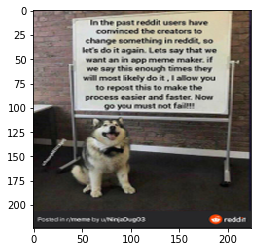

In [4]:
## load the image into the desired format

from PIL import Image
from PIL import ImageOps
import requests

def loadImage(filename):
    response = requests.get(filename, stream=True)
    image = Image.open(response.raw)
    image.thumbnail( ( 224, 224 ) )
    image = image.resize((224, 224), Image.ANTIALIAS)
    numpy_image = img_to_array(image)
    # get input to vgg model format: (batchsize, height, width, channels)
    image_batch = np.expand_dims(numpy_image, axis=0)
    return image_batch

# test function plot image
images = list(dframe['media']) 
filename = images[11]  
image_batch = loadImage(filename)
print('image batch size', image_batch.shape) # the vgg model takes a 244X244 size image
plt.imshow(np.uint8(image_batch[0]))

In [5]:
## get vgg model's predictions for what's in the image

def getPredictions(image_batch):
    processed_image = vgg16.preprocess_input(image_batch.copy())
    predictions = vgg_model.predict(processed_image)
    label = decode_predictions(predictions)
    return label

# test function print results
label = getPredictions(image_batch)    
print(label[0][0][1], ' - ', label[0][0][2], ' \n ',
      label[0][1][1], ' - ', label[0][1][2], ' \n ',
      label[0][2][1], ' - ', label[0][2][2], ' \n ',
      label[0][3][1], ' - ', label[0][3][2], ' \n ',
      label[0][4][1], ' - ', label[0][4][2], ' \n ')

pug  -  0.25179303  
  Chihuahua  -  0.091025524  
  Pekinese  -  0.08254428  
  Pomeranian  -  0.06585361  
  web_site  -  0.05593242  
 


In [142]:
## loop over many rows of data applying these two functions. expensive: run for sections of data at a time on multiple kernels

from time import time

store_labels = []
t0 = time()
for i in range(6000,6500):
    try:
        filename = images[i]  
        image_batch = loadImage(filename)
        label = getPredictions(image_batch)
        store_labels.append(label)
    except:
        store_labels.append(None)
t1 = time()

# check results
print(len(store_labels))
print('function vers1 takes %f' %(t1-t0)) # a little less than a second per image

500
function vers1 takes 461.930650


In [156]:
# add to vgg-identified features and their probabilities to dataframe
partial_df = dframe[0:len(combine_all)]
partial_df['vgg_general'] = combine_all
partial_df = partial_df.dropna(axis=0, how='any')

partial_df['vgg_feature_1'] = [item[0][0][1] for item in partial_df['vgg_general']]
partial_df['vgg1_prob'] = [item[0][0][2] for item in partial_df['vgg_general']]
partial_df['vgg_feature_2'] = [item[0][1][1] for item in partial_df['vgg_general']]
partial_df['vgg2_prob'] = [item[0][1][2] for item in partial_df['vgg_general']]
partial_df['vgg_feature_3'] = [item[0][2][1] for item in partial_df['vgg_general']]
partial_df['vgg3_prob'] = [item[0][2][2] for item in partial_df['vgg_general']]

# check:
partial_df.head()

,author,awards,created_utc,text_from_image,words,processed_words,downs,id,is_nsfw,media,...,avg_blueRGB,avg_tan,avg_orange,vgg_general,vgg_feature_1,vgg1_prob,vgg_feature_2,vgg2_prob,vgg_feature_3,vgg3_prob
1,L71U,[],1584295514,NICE DICK\r\n,Ricardo😎NICE DICK\r\n,"[ricardo, nice, dick]",0,fj5ixk,False,https://i.redd.it/w6acm47gmvm41.jpg,...,93.377158,2.784004,0.331221,"[[(n07248320, book_jacket, 0.54543704), (n0277...",book_jacket,0.545437,balance_beam,0.242594,parallel_bars,0.029977
2,Awesome-ness5,[],1584294841,Nvidia's calling on gaming PC owners to\r\nput...,Gamers AssembleNvidia's calling on gaming PC o...,"[gamer, assemblenvidia, call, game, owner, sys...",0,fj5bzj,False,https://i.redd.it/bqawbb5gkvm41.jpg,...,31.829427,3.555040,6.742880,"[[(n07248320, book_jacket, 0.48626116), (n0635...",book_jacket,0.486261,web_site,0.466624,comic_book,0.009492
7,notaspop,[],1584293653,When you post a low-effort meme\r\nfor fun to ...,I mean.... Not Corona time?When you post a low...,"[mean, corona, time, post, effort, meme, peopl...",0,fj50df,False,https://i.redd.it/v5pea6wwgvm41.jpg,...,163.097218,0.136924,0.000000,"[[(n03832673, notebook, 0.18715544), (n0635919...",notebook,0.187155,web_site,0.172692,computer_keyboard,0.164374
9,In_An_Elmo_Cult,[],1584293448,All of the internet:\r\nHe •I've seen this one...,.All of the internet:\r\nHe •I've seen this on...,"[internet, see, internet, explor, whatdo, mean...",0,fj4ycc,False,https://i.redd.it/hakptfr2gvm41.png,...,221.692281,6.094527,12.068732,"[[(n06359193, web_site, 0.95977473), (n0724832...",web_site,0.959775,book_jacket,0.007812,comic_book,0.003456
15,brutalsam,[],1584292201,Humans: we should prevent this virus from spre...,one day humans will be the reason of their ext...,"[human, reason, prevent, virus, spread, human,...",0,fj4m0x,False,https://i.redd.it/4apsvkjgcvm41.jpg,...,107.692454,48.280000,0.073221,"[[(n03814906, necklace, 0.30186796), (n0283439...",necklace,0.301868,bib,0.219083,sunglasses,0.098275


In [159]:
# export to file
partial_df.to_json(r'./partial_df.json')

# check
test = pd.read_json ('./partial_df.json')
test.shape

(5582, 33)